In [ ]:
from pandas_profiling import ProfileReport
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import ppscore as pps

# Get Data

In [2]:
train = pd.read_csv("Data/train.csv", index_col = 0)
train.head()

f1        f2         f3        f4       f5        f6       f7  \
id                                                                       
0   0.10859  0.004314    -37.566  0.017364  0.28915 -10.25100   135.12   
1   0.10090  0.299610  11822.000  0.276500  0.45970  -0.83733  1721.90   
2   0.17803 -0.006980    907.270  0.272140  0.45948   0.17327  2298.00   
3   0.15236  0.007259    780.100  0.025179  0.51947   7.49140   112.51   
4   0.11623  0.502900   -109.150  0.297910  0.34490  -0.40932  2538.90   

          f8            f9        f10  ...     f110    f111     f112  \
id                                     ...                             
0   168900.0  3.992400e+14     86.489  ... -12.2280  1.7482  1.90960   
1   119810.0  3.874100e+15   9953.600  ... -56.7580  4.1684  0.34808   
2   360650.0  1.224500e+13  15827.000  ...  -5.7688  1.2042  0.26290   
3   259490.0  7.781400e+13    -36.837  ... -34.8580  2.0694  0.79631   
4    65332.0  1.907200e+15    144.120  ... -13.6410  1.5298  1.14640   

        f113      f114    f115          f116    f117     f118  claim  
id                                                                    
0   -7.11570   4378.80  1.2096  8.613400e+14   140.1  1.01770      1  
1    4.14200    913.23  1.2464  7.575100e+15  1861.0  0.28359      0  
2    8.13120  45119.00  1.1764  3.218100e+14  3838.2  0.40690      1  
3  -16.33600   4952.40  1.1784  4.533000e+12  4889.1  0.51486      1  
4   -0.43124   3856.50  1.4830 -8.991300e+12     NaN  0.23049      1  

[5 rows x 119 columns]

In [3]:
train.shape

(957919, 119)

# Pandas Profiling

In [7]:
profile = ProfileReport(train.sample(n = 100000), title="Kaggle Playground Series September 2021",
                       correlations={
                                "pearson": {"calculate": False},
                                "spearman": {"calculate": True},
                                "kendall": {"calculate": False},
                                "phi_k": {"calculate": True},
                                "cramers": {"calculate": False},
                            })
profile.to_file("pandas_profiling_report.html")

Summarize dataset:   0%|          | 0/130 [00:00<?, ?it/s]

C:\Users\I539756\.virtualenvs\202109_TabularPlaygroundSeries-75bSHUOP\lib\site-packages\missingno\missingno.py:250: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right', fontsize=fontsize)
C:\Users\I539756\.virtualenvs\202109_TabularPlaygroundSeries-75bSHUOP\lib\site-packages\pandas_profiling\model\summary.py:194: UserWarning: There was an attempt to generate the bar missing values diagrams, but this failed.
    To hide this warning, disable the calculation
    (using `df.profile_report(missing_diagrams={"bar": False}`)
    If this is problematic for your use case, please report this as an issue:
    https://github.com/pandas-profiling/pandas-profiling/issues
    (include the error message: 'The number of FixedLocator locations (7), usually from a call to set_ticks, does not match the number of ticklabels (120).')
  warnings.warn(
C:\Users\I539756\.virtualenvs\202109_TabularPlaygroundSeries-75bSH

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

# Correlation with target variable

Because our target variable is categorical (specifically binary) it's not reasonable to use the spearman correlation for example to measure the correlation between the features and the target.

(Intersting link on the topic: https://medium.com/@outside2SDs/an-overview-of-correlation-measures-between-categorical-and-continuous-variables-4c7f85610365)

## Point Biserial Correlation
The point biserial correlation coefficient (rpb) is a correlation coefficient used when one variable (e.g. Y) is dichotomous;  <br>
https://en.wikipedia.org/wiki/Point-biserial_correlation_coefficient<br>
The point biserial correlation coefficient is a special case of Pearson’s correlation coefficient. 
- Similar to the Pearson coefficient, the point biserial correlation can range from -1 to +1.
- The point biserial calculation assumes that the continuous variable is normally distributed and homoscedastic.
- If the dichotomous variable is artificially binarized, i.e. there is likely continuous data underlying it, biserial correlation is a more apt measurement of similarity. There is a simple formula to calculate the biserial correlation from point biserial correlation, but nonetheless this is an important point to keep in mind.

In [55]:
def feature_generation(data):
    
    data = data.copy()

    # add feature with number of na's per row + standard deviation
    features = [col for col in data.columns if 'f' in col] # if 'f' is in the name
    data['count_na'] = data[features].isna().sum(axis=1)

    features += ['count_na']

    # now do imputation with mean
    data[features] = data[features].fillna(data[features].mean())

    return data

train_w_nan = feature_generation(train)

In [32]:
from scipy.stats import pointbiserialr

correlation_w_target = pd.Series(index = [f"f{i}" for i in range(1, 119)] + ['count_na'])

for feature in [f"f{i}" for i in range(1, 119)] + ['count_na']:
    a = train[feature]
    b = train.claim
    correlation_w_target.loc[feature] = pointbiserialr(a[~a.isnull()], b[~a.isnull()])[0]

C:\Users\I539756\AppData\Local\Temp/ipykernel_20184/1849971000.py:3: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  correlation_w_target = pd.Series(index = [f"f{i}" for i in range(1, 119)] + ['count_na'])


In [33]:
# Sort values by absolute correlation
correlation_w_target = correlation_w_target.loc[correlation_w_target.abs().sort_values(ascending = False).index]

print("Top 10 feature with highest correlation with target:")
display(correlation_w_target.iloc[:10])

Top 10 feature with highest correlation with target:


count_na    0.452653
f34        -0.021332
f57        -0.017829
f45        -0.017548
f95         0.014650
f21        -0.014225
f8          0.014195
f31         0.013788
f35         0.013666
f52        -0.012256
dtype: float64

# Predictive power between features and target

In [ ]:
predictive_power_w_target = pps.predictors(train, "claim")

# Predictive power between all features

In [ ]:
predictive_power = pps.matrix(train)

# Further Analysis

ERROR! Session/line number was not unique in database. History logging moved to new session 1421


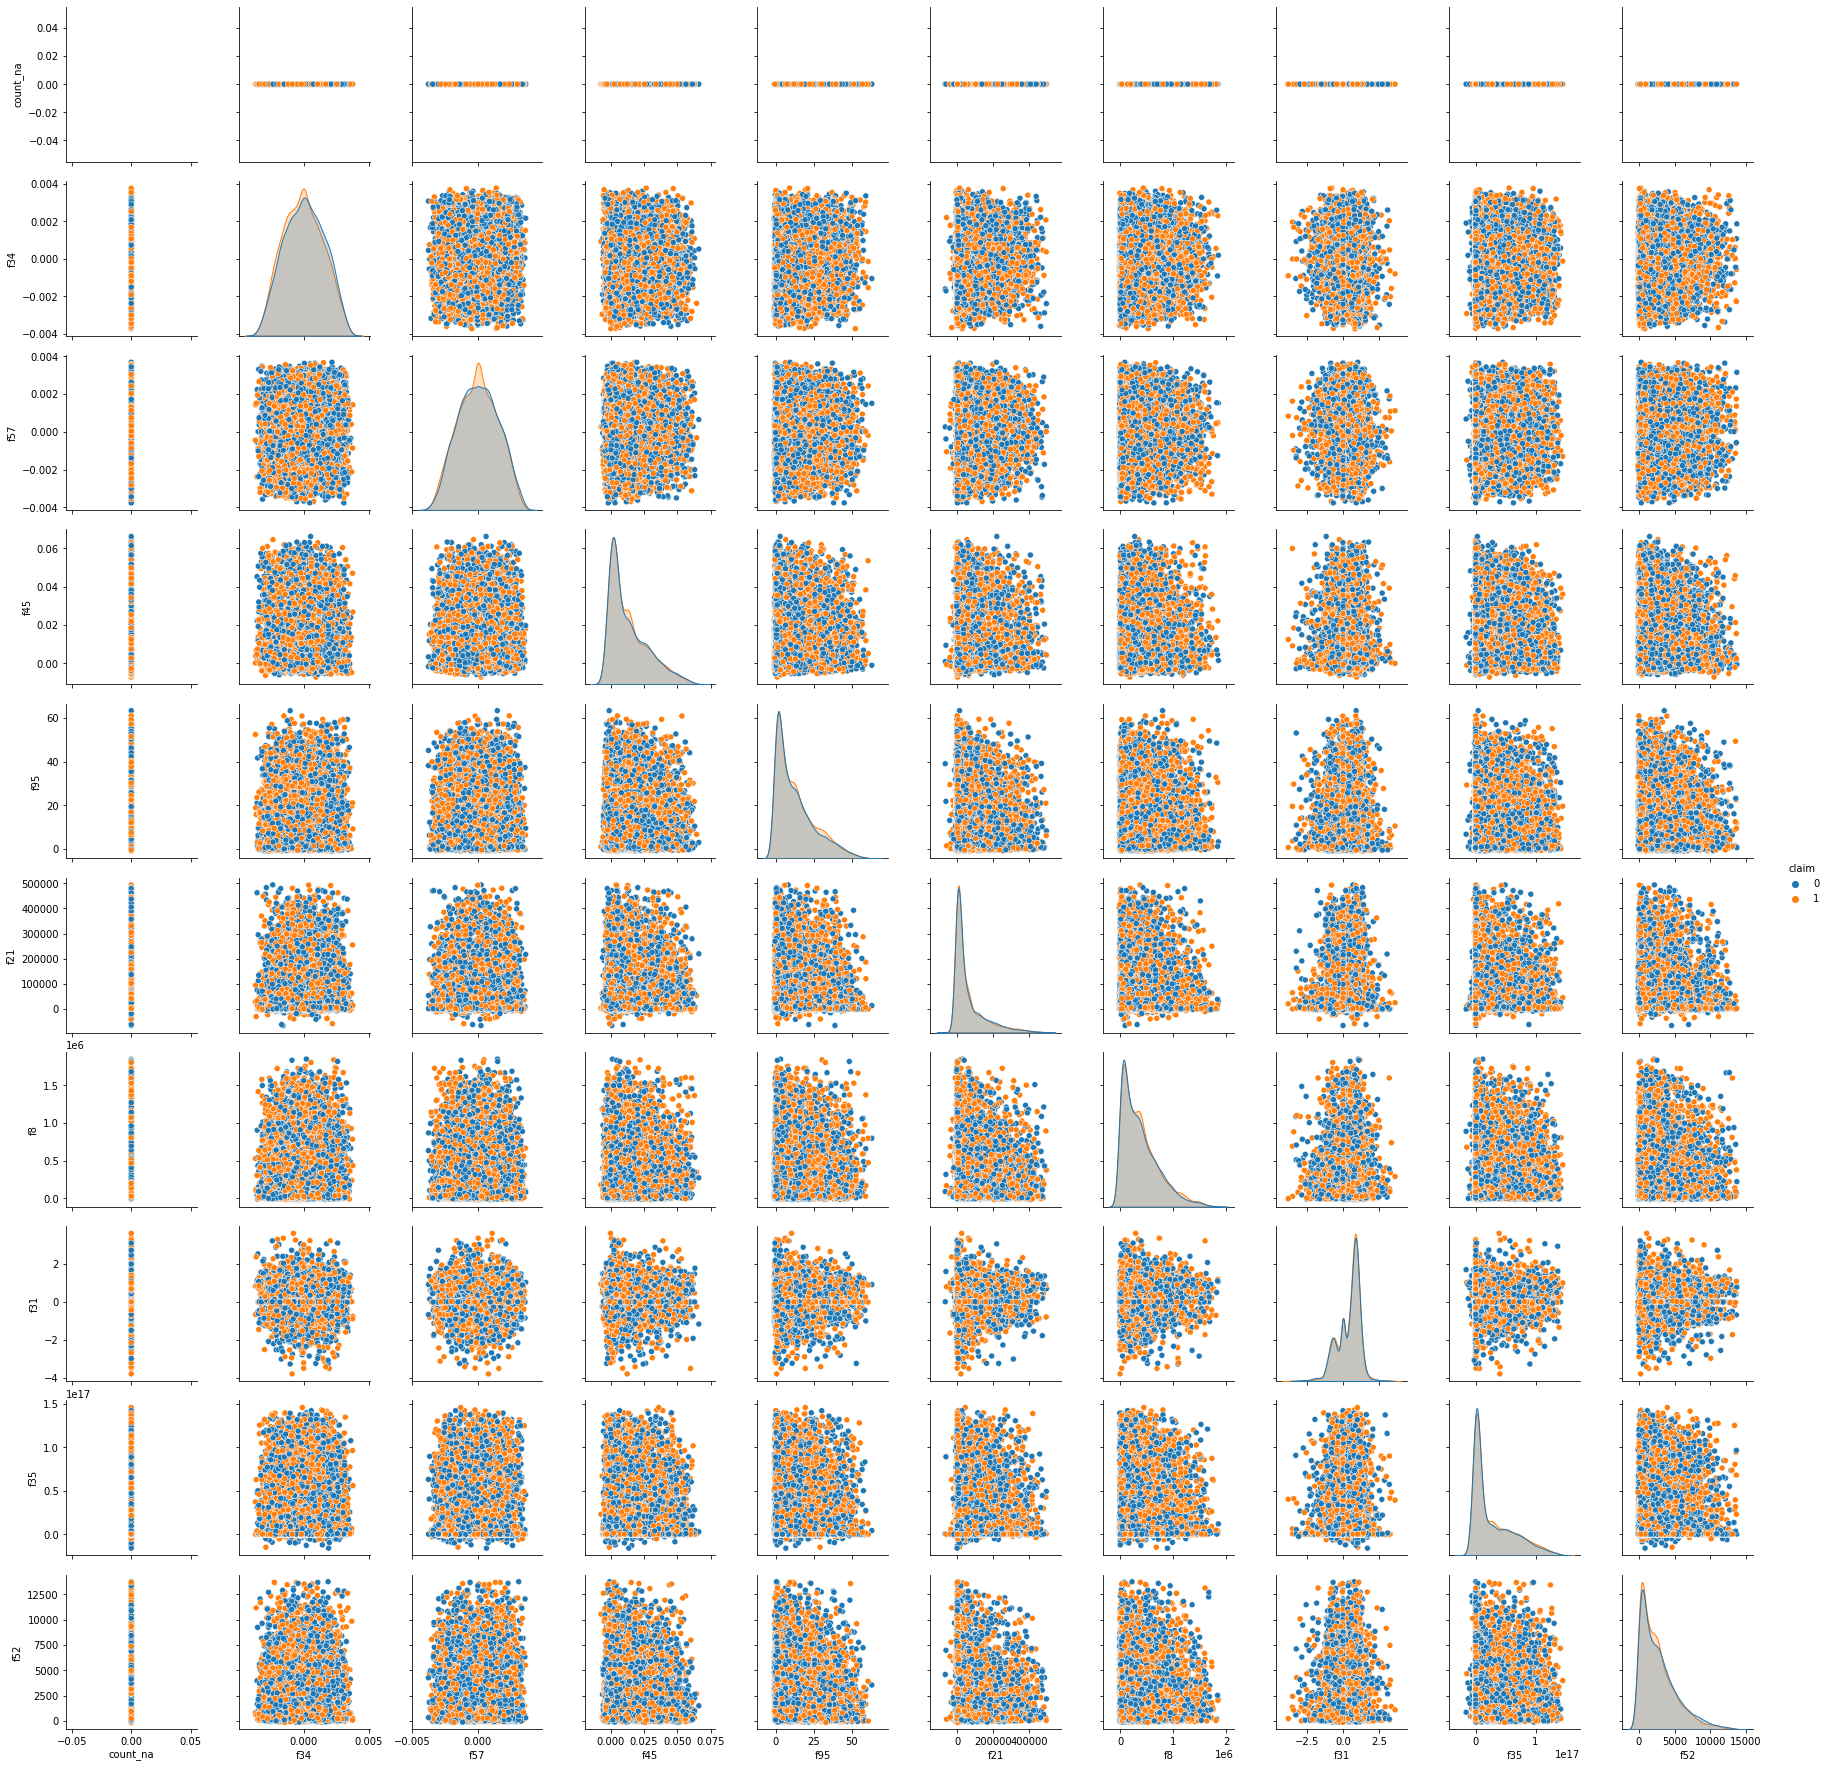

In [38]:
sns.pairplot(data = train_w_nan[list(correlation_w_target.iloc[:10].index) + ['claim']].sample(10000), hue = 'claim')

# Missing values

In [56]:
n_missing_values = train.isna().mean()
n_missing_values[n_missing_values != 0]

f1      0.015917
f2      0.015857
f3      0.016172
f4      0.016244
f5      0.016082
          ...   
f114    0.016116
f115    0.016243
f116    0.016274
f117    0.016084
f118    0.015880
Length: 118, dtype: float64

In [76]:
n_missing_values.max()

0.016366728293310814

In [60]:
train[train.f1.isnull()]

f1        f2         f3        f4        f5       f6       f7  \
id                                                                      
51     NaN  0.271780    406.700  0.002204  0.297680 -1.54720   638.90   
127    NaN  0.479470    -65.067  0.029566  0.300620  0.40239  3928.70   
281    NaN  0.304450    677.020  0.043649  0.311150  1.41540  2005.30   
297    NaN  0.451890    407.180  0.440000  0.235530 -1.35870   359.31   
344    NaN  0.497790   1887.100  0.287000 -0.002191 -0.17440  2796.60   
...     ..       ...        ...       ...       ...      ...      ...   
957785 NaN  0.002492  -1140.000  0.019253  0.332310 -0.70586   795.41   
957801 NaN  0.497880   2631.700  0.590110 -0.005218 -4.16410   118.32   
957810 NaN  0.485200  17075.000  0.140110  0.003226 -0.97246  2929.60   
957826 NaN  0.396950   4463.800  0.238530  0.349820      NaN  1805.50   
957867 NaN  0.346860   3717.400  0.646540  0.435000  1.42070  2025.30   

              f8            f9        f10  ...      f110    f111     f112  \
id                                         ...                              
51       63404.0  3.372000e+14     37.277  ...  -0.14702  3.7175  1.30440   
127     344660.0  4.278300e+14   6613.800  ... -42.49400  1.7043 -2.29070   
281     255730.0  1.633400e+15   1263.100  ... -62.19100  2.7779  3.60570   
297     407060.0  2.954000e+15  14336.000  ...  -0.39556  1.9789  2.08150   
344     378570.0  3.376400e+14     16.217  ... -23.61700  1.7214      NaN   
...          ...           ...        ...  ...       ...     ...      ...   
957785  345440.0  7.455900e+12    791.300  ...  -0.20679  1.5318 -3.32440   
957801   41433.0 -7.841800e+12   1633.300  ... -32.49700  1.4920  0.95403   
957810  143910.0 -8.859100e+13   -104.760  ... -39.50100  1.8828  2.64170   
957826  594150.0  3.563500e+15  12538.000  ...  -8.79540  1.5404 -0.30432   
957867  258160.0  9.519900e+13    377.180  ... -17.45300  1.5989  1.92270   

           f113       f114    f115          f116     f117     f118  claim  
id                                                                         
51     -2.81610   25339.00  1.2042  1.863500e+17   645.69  0.64583      0  
127    -8.07470   11953.00  1.4716  4.088000e+13  5827.80  0.36847      1  
281     4.79510    9670.10  1.1917  9.083200e+16  4816.40  0.35410      1  
297    -2.78080    3743.90  1.1881  2.721900e+14  8898.60  0.16052      0  
344     3.87790   27084.00  1.1524  1.393500e+16  2221.80  0.20749      1  
...         ...        ...     ...           ...      ...      ...    ...  
957785  2.01330  117320.00  1.2578  5.022800e+16  2110.80  0.90192      0  
957801 -8.46920    -349.11  1.1726  1.435800e+15  7490.10  1.34750      1  
957810 -0.43623    5162.80  1.1798  8.939900e+16  3442.80  0.30301      0  
957826  3.26950   36023.00  1.3548  3.076400e+13  2014.70  0.11739      1  
957867 -2.83100  139090.00  1.0853  2.736400e+14  1726.80  0.93526      1  

[15247 rows x 119 columns]

# Feature distribution

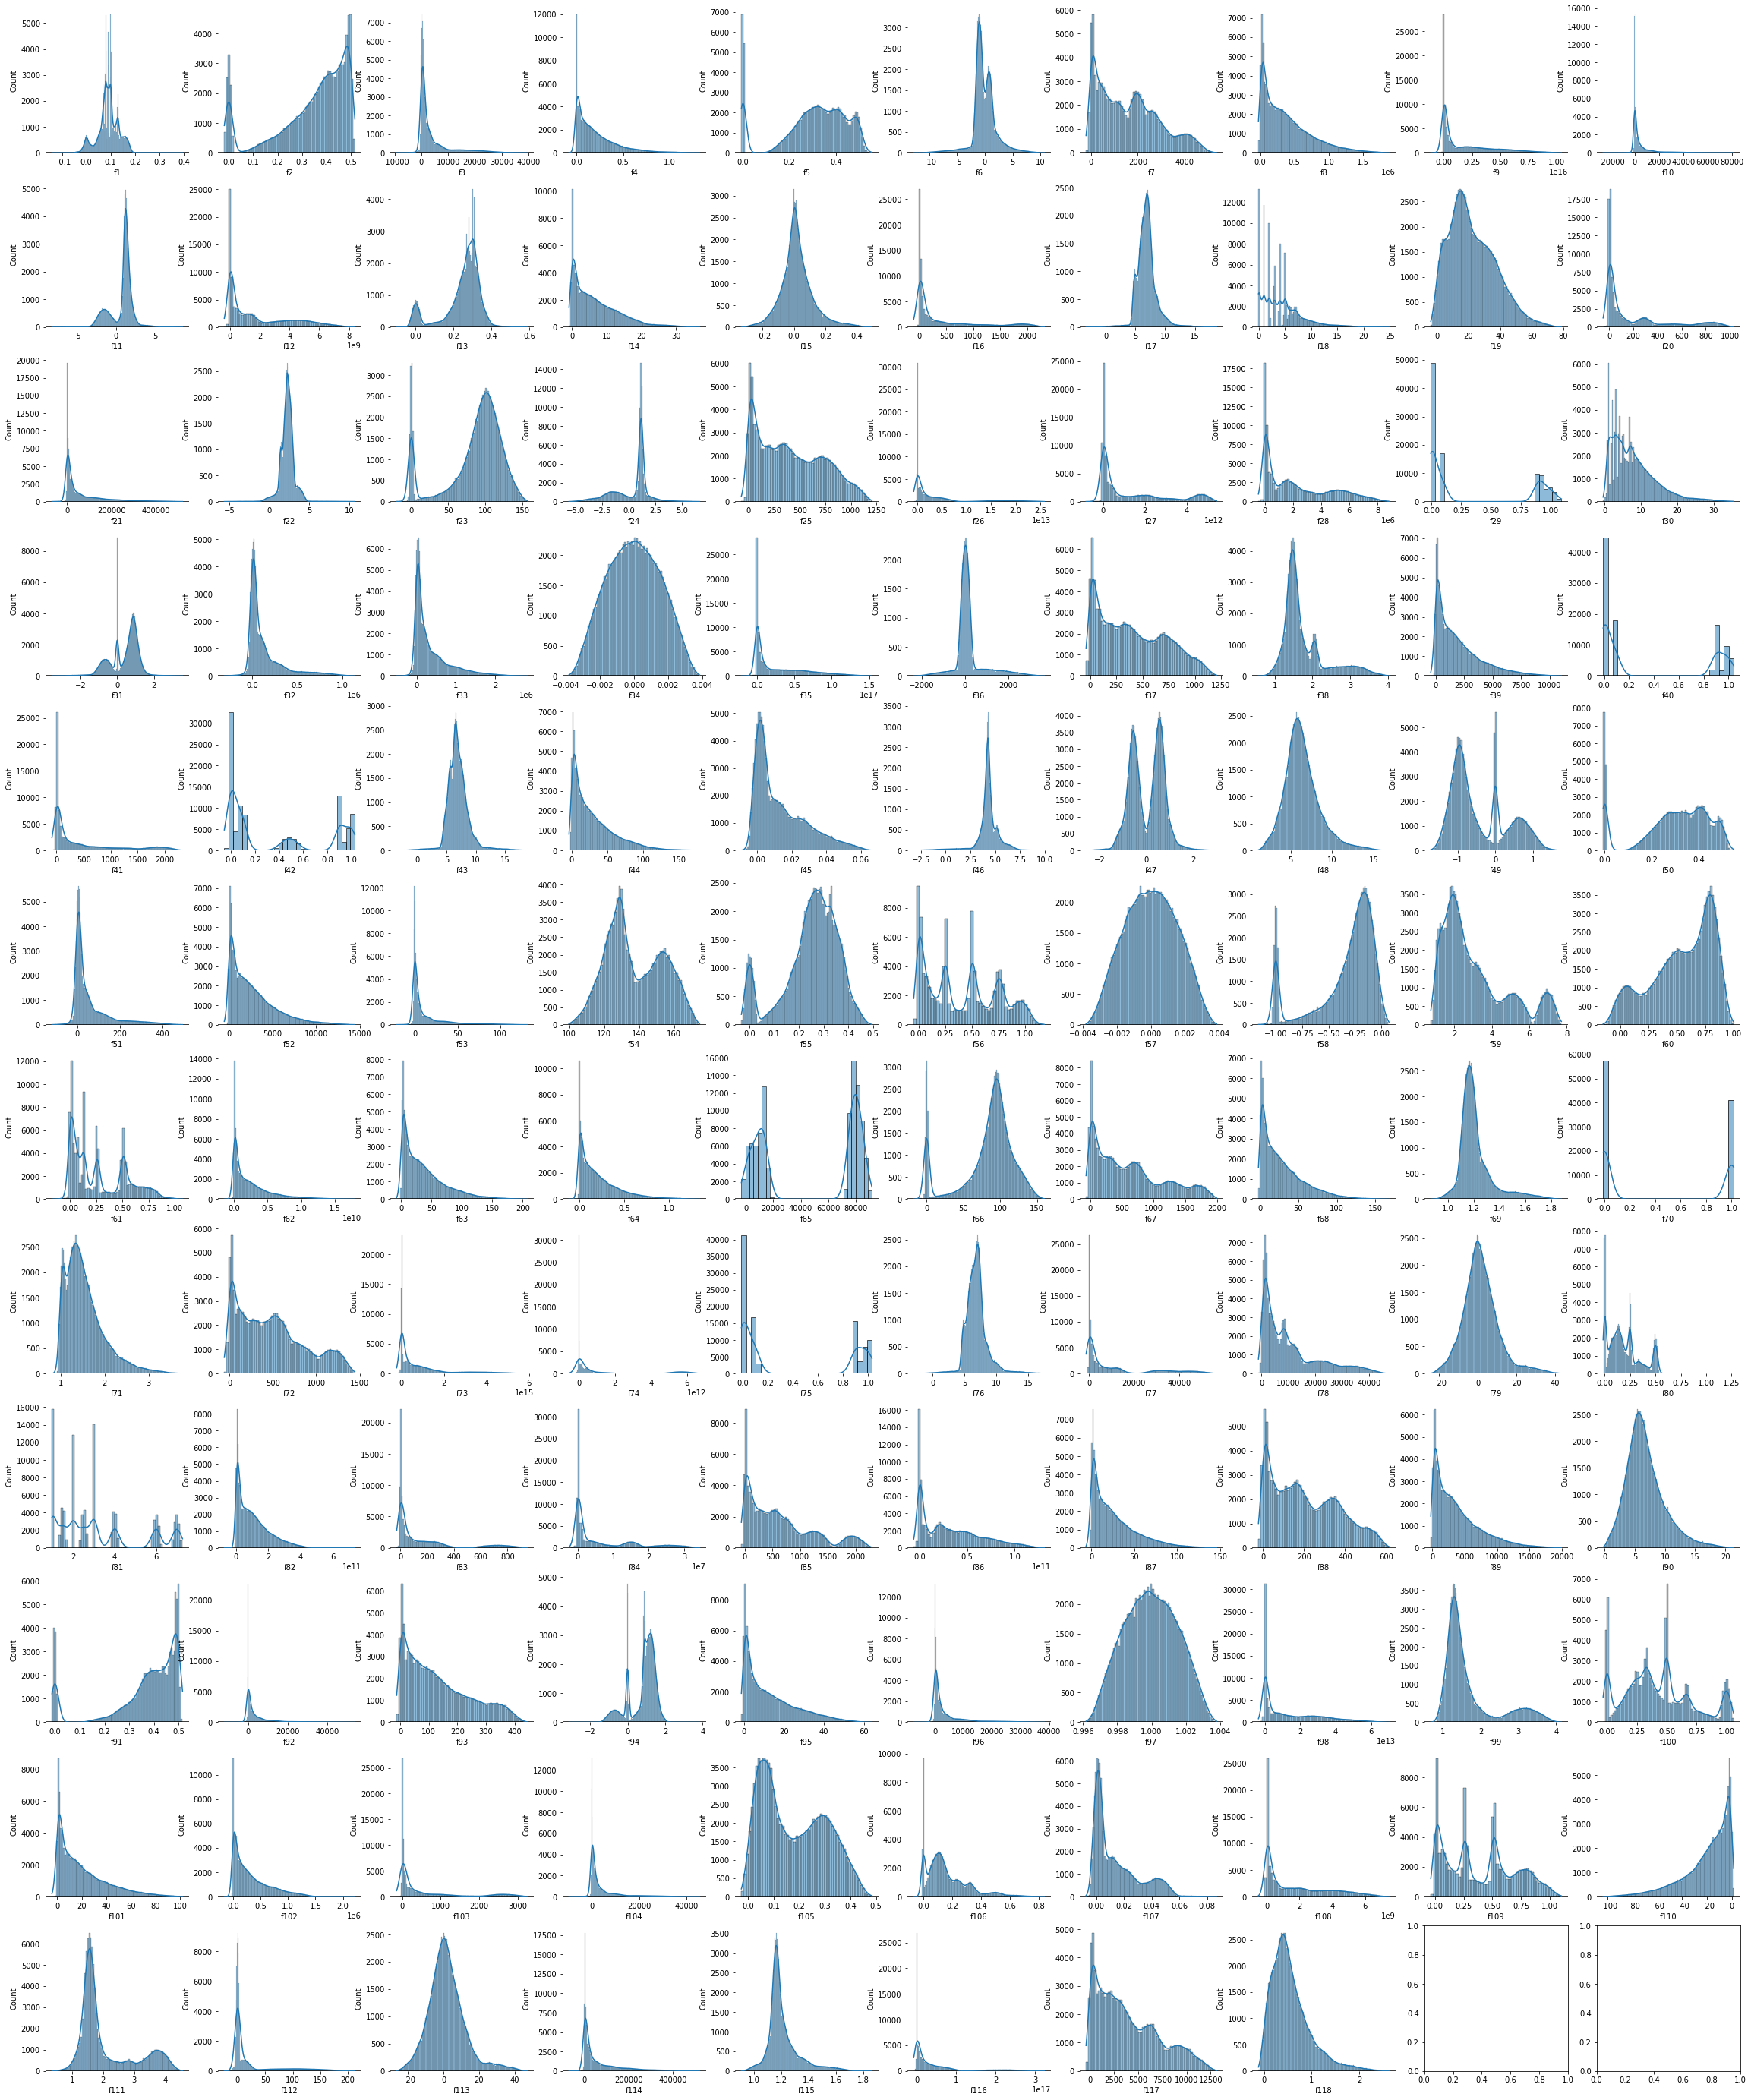

In [75]:
fig, axes = plt.subplots(12, 10, figsize=(40, 50))
for i in range(1, 119):
    
    row = int((i-1)/10)
    col = (i-1) % 10
    
    axes[row, col].set_frame_on(False) #Remove both axes
    axes[row, col].axhline(0,color='black') #Put the x axis back
    
    sns.histplot(data = train.sample(100000), x = f'f{i}', ax = axes[row, col], kde = True, line_kws = {'color':'red'})

# Analysis of most important features for model

In [4]:
test = pd.read_csv("Data/test.csv", index_col = 0)
test.head()

f1        f2        f3       f4       f5       f6       f7  \
id                                                                         
957919  0.165850  0.487050   1295.00  0.02310  0.31900  0.90188   573.29   
957920  0.129650  0.373480   1763.00  0.72884  0.33247 -1.26310   875.55   
957921  0.120190  0.445210    736.26  0.04615  0.29605  0.31665  2659.50   
957922  0.054008  0.395960    996.14  0.85934  0.36678 -0.17060   386.56   
957923  0.079947 -0.006919  10574.00  0.34845  0.45008 -1.84200  3027.00   

              f8            f9       f10  ...     f109     f110    f111  \
id                                        ...                             
957919    3743.7  2.705700e+12  6221.000  ...  0.16253 -22.1890  2.0655   
957920  554370.0  5.955700e+14   934.430  ...  0.81528  -1.6342  1.5736   
957921  317140.0  3.977800e+14   131.810  ...  0.81831 -32.7800  2.1364   
957922  325680.0 -3.432200e+13   -26.473  ...  0.86559  -2.4162  1.5199   
957923  428150.0  9.291500e+11  5999.400  ...  0.25190 -18.6300  3.7387   

            f112     f113     f114    f115          f116    f117     f118  
id                                                                         
957919  0.430880 -10.7410  81606.0  1.1940  1.980400e+14  2017.1  0.46357  
957920 -1.071200  11.8320  90114.0  1.1507  4.388000e+16  6638.9  0.28125  
957921 -1.931200  -3.2804  37739.0  1.1548  1.718100e+14  5844.0  0.13797  
957922 -0.011633   1.3840  26849.0  1.1490  2.138800e+17  6173.3  0.32910  
957923  0.757080  -4.9405  50336.0  1.2488  2.151300e+17  2250.1  0.33796  

[5 rows x 118 columns]

In [54]:
import ipywidgets as widgets
from IPython.display import display, clear_output

feature_dropdown = widgets.Dropdown(
    options=[f"f{i}" for i in range(1, 119)],
    description='Feature:',
    disabled=False,
)

def plot_feature_distribution(selected_feature):
   
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    sns.histplot(data = train, x = selected_feature, bins = 30, ax = axes[0])
    axes[0].set_title(f"Distribution of {selected_feature} in the training set")
    
    sns.histplot(data = test, x = selected_feature, bins = 30, ax = axes[1])
    axes[1].set_title(f"Distribution of {selected_feature} in the test set")

    plt.show()
    
widgets.interact(plot_feature_distribution, selected_feature=feature_dropdown);

interactive(children=(Dropdown(description='Feature:', options=('f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8'…

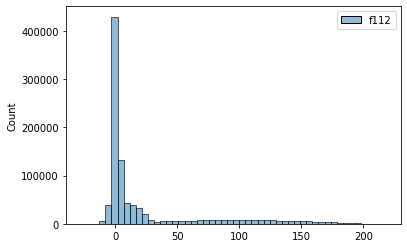

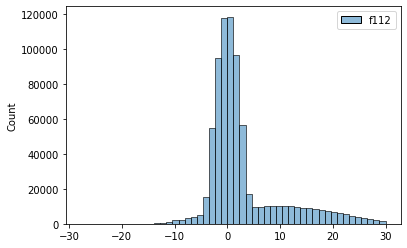

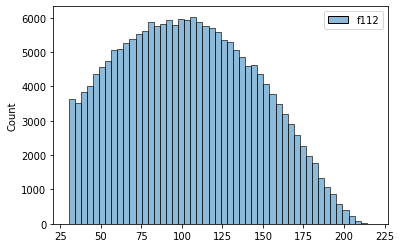

In [130]:
plot_each_mode('f112', 30)

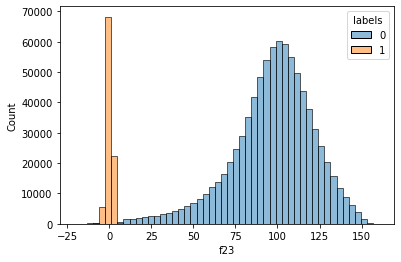

In [93]:
temp = gmmfeature("f23")

In [95]:
temp[temp.labels == 1].f23.max()

6.1989

In [99]:
temp[(temp.labels == 0) & (temp.f23 > 0)].f23.min()

6.2072

In [97]:
temp

f23  labels
id                      
0       135.3200       0
1       125.8100       0
2         1.6826       1
3        92.1420       0
4        96.7250       0
...          ...     ...
957913   59.4290       0
957914  136.5100       0
957916  100.5400       0
957917  118.0500       0
957918  116.5000       0

[942563 rows x 2 columns]

In [71]:
def plot_each_mode(feature, threshold):
    
    feature_data = train[[feature]]
    
    v1 = feature_data[feature_data <= threshold]
    v2 = feature_data[feature_data > threshold]
    
    sns.histplot(feature_data, bins = 50)
    plt.show()
    
    plt.show()
    
    sns.histplot(v2, bins = 50)
    plt.show()

In [92]:
def gmmfeature(feature):
    gmm = GaussianMixture(2)
    gmm.fit(train[[feature]].dropna()) 
    
    temp = train[[feature]].dropna().copy()
    temp["labels"] = gmm.predict(train[[feature]].dropna())
    
    sns.histplot(data = temp, x = feature, hue = 'labels', bins = 50)
    plt.show()
    return temp

In [61]:
from sklearn.preprocessing import  power_transform

def plot_before_after_power_transform(feature):
    
    feature_data = train[[feature]].copy()
    
    transformed_feature_data = quantile_transform(feature_data)
    
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    sns.histplot(feature_data, bins = 50, ax = axes[0])
    sns.histplot(transformed_feature_data, bins = 50, ax = axes[1])    
    plt.show()

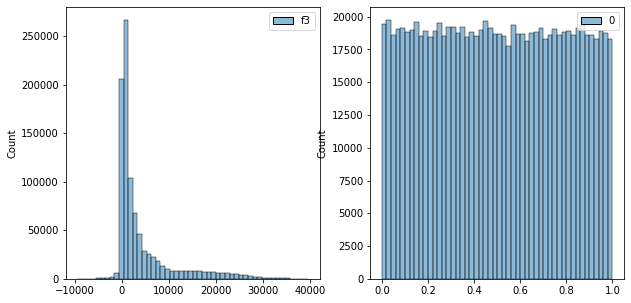

In [62]:
plot_before_after_power_transform('f3')

<AxesSubplot:xlabel='f3', ylabel='Count'>

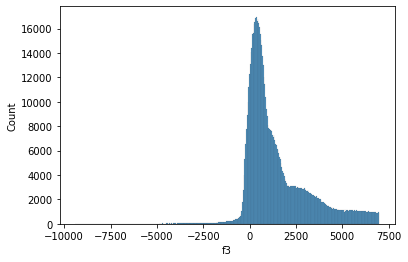

In [63]:
sns.histplot(train.f3[train.f3 < 7000])